In [3]:
from diffmain import *
from DataL import *
import glob
import sys
import os
import re
import torch    
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pdb
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from vae import *
import DataL

1435


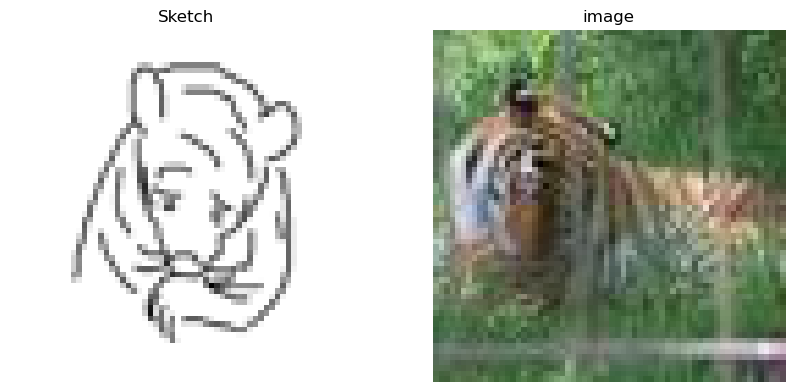

In [5]:
transform = transforms.ToTensor()
SketchySet = get_sketchimageclass('tiger', 'cat', transform=transform, size=64)
#SketchySet = DataL.create_smaller_dataset(SketchySet, 12)

print(len(SketchySet))

i=random.randint(0,len(SketchySet)-1)
sk,im = SketchySet[i]

# Convert the tensors back to numpy arrays
sk = sk.numpy()
im = im.numpy()

sk=np.array(sk).transpose((1,2,0))
im=np.array(im).transpose((1,2,0))
#print(im)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sk)
ax[0].set_title('Sketch')
ax[0].axis('off')

ax[1].imshow(im)
ax[1].set_title('image')
ax[1].axis('off')

plt.show()

In [6]:
diffusion_steps = 1000
architecture = "UNet"
sampling_steps = 250
DDIM = True


seed = 112233
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
model = unets.__dict__[architecture](
    image_size=32,
    in_channels=1,
    out_channels=1).to(device)

#model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))   

diffusion = GuassianDiffusion(diffusion_steps, device = device)

lr = 0.001
ngpus = torch.cuda.device_count()
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "12355"
os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"
local_rank = int(os.getenv("LOCAL_RANK", "0"))

device = "cuda:{}".format(local_rank)
torch.cuda.set_device(device)
torch.manual_seed(seed + local_rank)
np.random.seed(seed + local_rank)
batch_size = 32

if torch.distributed.is_initialized():
    torch.distributed.destroy_process_group()

if ngpus > 1:
    if local_rank == 0:
        print(f"Using distributed training on {ngpus} gpus.")
    batch_size = batch_size // ngpus
    torch.distributed.init_process_group(backend="nccl", init_method="env://")
    model = DDP(model, device_ids=[local_rank], output_device=local_rank)

#train_set=create_smaller_dataset(get_miniset(), factor=50)

sampler = DistributedSampler(SketchySet) if ngpus > 1 else None

train_loader = DataLoader(SketchySet, batch_size=batch_size, sampler=sampler, num_workers=1, pin_memory=True)

if local_rank == 0:
    print(
        f"Training dataset loaded: Number of batches: {len(train_loader)}, Number of images: {len(SketchySet)}"
    )

Using distributed training on 8 gpus.
Training dataset loaded: Number of batches: 16, Number of images: 61


In [5]:
latent_size=32
vae=VAE((3,64,64), latent_size*latent_size).to(device)

In [6]:
epochs = 2
optimizer = optim.AdamW(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)  # Decays the learning rate by a factor of 0.1 every 30 epochs
# Other schedulers we can use are: StepLR, ExponentialLR, ReduceLROnPlateau, CosineAnnealingLR
model.train()
torch.cuda.empty_cache()
Tloss = []
for epoch in tqdm(range(epochs)):
    totalloss=0
    #train_one_epoch(model, train_loader, optimizer, device, epoch, diffusion)
    for step, (sketch, photo) in enumerate(train_loader):
        assert (photo.max().item() <= 1) and (0 <= photo.min().item())
        photo = photo.to(device)
        sketch = sketch.to(device)
        #photo, sketch = (2 * photo - 1, 2*sketch-1)
        #pdb.set_trace()
        print("Starting encoding")
        mu, logv = vae.forward_encoder(sketch)
        
        #pdb.set_trace()
        #sketch=sketch.detach().cpu()
        latent_sketch= vae.sampling(mu, logv)
        latent_sketch = latent_sketch.reshape(batch_size, 3, latent_size,latent_size)
        
        print("Latent sketch shape", latent_sketch.shape)
        
        t = torch.randint(diffusion.timesteps, (len(latent_sketch),), dtype=torch.int64).to(device)
        xt, eps = diffusion.sample_from_forward_process(latent_sketch, t)
        
        print("successfully diffused")
        print("Xt shape", xt.shape)
        
        pred_eps = model(xt, t, y = None)
        print("Noise predicted")
        print("Shape: ", pred_eps.shape)
        latent_img=diffusion.sample_from_reverse_process(model, xt, diffusion.timesteps)
        print("latent image generated")
        latent_img=latent_img.reshape(batch_size, latent_size*latent_size)
        pred_img=vae.forward_decoder(latent_img)
        print("calculating loss")
        loss = ((pred_eps - eps) ** 2).mean() + ((pred_img - photo)).mean()

        
        print("Working")
        
        #loss=loss/4
        totalloss+=loss.item()
        loss.backward()
        #if step%4 == 0:
        optimizer.step()
        optimizer.zero_grad()  
    
    totalloss=totalloss/len(train_loader)
    Tloss.append(totalloss)
    scheduler.step()
    print("Epoch: ", epoch)
    print("Loss: ", loss.item())
    for param_group in optimizer.param_groups:
        print("Current learning rate is: ", param_group['lr'])

  0%|                                                                                                 | 0/2 [00:00<?, ?it/s]

Starting encoding
Latent sketch shape torch.Size([4, 1, 32, 32])
successfully diffused
Xt shape torch.Size([4, 1, 32, 32])
Noise predicted
Shape:  torch.Size([4, 1, 32, 32])
latent image generated
calculating loss
Working
Starting encoding
Latent sketch shape torch.Size([4, 1, 32, 32])
successfully diffused
Xt shape torch.Size([4, 1, 32, 32])
Noise predicted
Shape:  torch.Size([4, 1, 32, 32])
latent image generated
calculating loss
Working
Starting encoding
Latent sketch shape torch.Size([4, 1, 32, 32])
successfully diffused
Xt shape torch.Size([4, 1, 32, 32])
Noise predicted
Shape:  torch.Size([4, 1, 32, 32])
latent image generated
calculating loss
Working
Starting encoding
Latent sketch shape torch.Size([4, 1, 32, 32])
successfully diffused
Xt shape torch.Size([4, 1, 32, 32])
Noise predicted
Shape:  torch.Size([4, 1, 32, 32])
latent image generated
calculating loss
Working
Starting encoding
Latent sketch shape torch.Size([4, 1, 32, 32])
successfully diffused
Xt shape torch.Size([4, 1

  0%|                                                                                                 | 0/2 [09:38<?, ?it/s]


RuntimeError: shape '[4, 1, 32, 32]' is invalid for input of size 1024

In [12]:
#torch.save(model, "pipelinev1_model.pth")
#torch.save(vae,"pipelinev1_vae.pth")